# Kalman Filter in Biomedical Signal Processing
## Interactive Demonstration Notebook
### Advanced State Estimation for Noisy Biosignals

This notebook demonstrates Kalman filtering techniques for biomedical applications:
- Linear Kalman Filter (KF)
- Extended Kalman Filter (EKF)
- Unscented Kalman Filter (UKF)
- Applications to ECG, heart rate estimation, and respiratory tracking
- Comparison with traditional filtering methods

## Section 1: Setup and Installation

In [1]:
# Install required packages
!pip install numpy matplotlib scipy filterpy -q

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from filterpy.kalman import KalmanFilter, ExtendedKalmanFilter, UnscentedKalmanFilter, MerweScaledSigmaPoints
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("All packages installed successfully!")
print("Ready to explore Kalman filtering for biomedical signals")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
All packages installed successfully!
Ready to explore Kalman filtering for biomedical signals


## Section 2: Kalman Filter Theory Overview

### What is a Kalman Filter?

The Kalman filter is an **optimal recursive state estimator** that uses:
- **Prediction**: Uses system model to predict next state
- **Update**: Corrects prediction using noisy measurements

### State Space Model

The Kalman filter operates on a state-space model:

**State Equation (Process Model):**
```
x(k) = F·x(k-1) + B·u(k) + w(k)
```

**Measurement Equation (Observation Model):**
```
z(k) = H·x(k) + v(k)
```

Where:
- `x(k)` = State vector at time k
- `F` = State transition matrix
- `B` = Control input matrix
- `u(k)` = Control input
- `w(k)` = Process noise ~ N(0, Q)
- `z(k)` = Measurement vector
- `H` = Measurement matrix
- `v(k)` = Measurement noise ~ N(0, R)

### The Kalman Filter Algorithm

**Predict Step:**
1. State prediction: `x̂(k|k-1) = F·x̂(k-1|k-1) + B·u(k)`
2. Covariance prediction: `P(k|k-1) = F·P(k-1|k-1)·F^T + Q`

**Update Step:**
1. Innovation: `y(k) = z(k) - H·x̂(k|k-1)`
2. Innovation covariance: `S(k) = H·P(k|k-1)·H^T + R`
3. Kalman gain: `K(k) = P(k|k-1)·H^T·S(k)^(-1)`
4. State update: `x̂(k|k) = x̂(k|k-1) + K(k)·y(k)`
5. Covariance update: `P(k|k) = (I - K(k)·H)·P(k|k-1)`

## Section 3: Example 1 - Simple Position and Velocity Tracking

Let's start with a simple example: tracking position with noisy measurements.

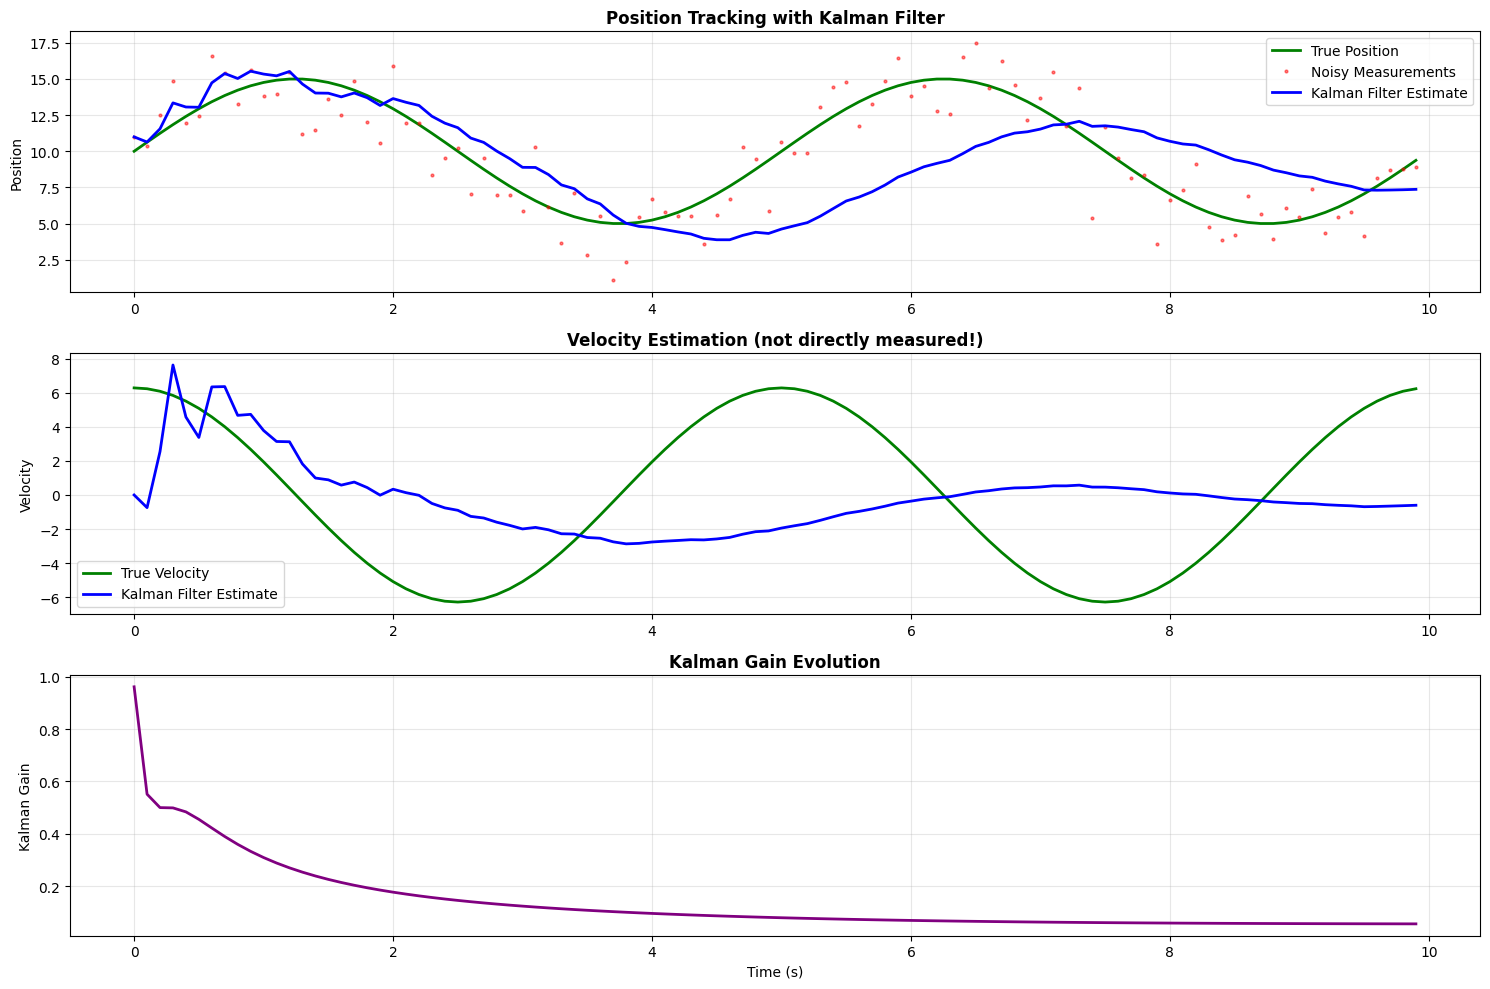


PERFORMANCE METRICS
Raw Measurement MSE:     3.3092
Kalman Filter MSE:       10.0295
MSE Reduction:           -203.08%


In [2]:
# Generate true trajectory (constant velocity model)
dt = 0.1  # Time step (100ms)
t = np.arange(0, 10, dt)
N = len(t)

# True position (sine wave to simulate breathing motion)
true_position = 10 + 5 * np.sin(2 * np.pi * 0.2 * t)
true_velocity = 5 * 2 * np.pi * 0.2 * np.cos(2 * np.pi * 0.2 * t)

# Add measurement noise
measurement_noise_std = 2.0
measurements = true_position + np.random.normal(0, measurement_noise_std, N)

# Initialize Kalman Filter
kf = KalmanFilter(dim_x=2, dim_z=1)  # 2 state variables (position, velocity), 1 measurement

# State transition matrix (constant velocity model)
kf.F = np.array([[1, dt],   # position = position + velocity*dt
                 [0, 1]])    # velocity = velocity

# Measurement function (we only measure position)
kf.H = np.array([[1, 0]])

# Measurement noise covariance
kf.R = np.array([[measurement_noise_std**2]])

# Process noise covariance
q = 0.1  # Process noise magnitude
kf.Q = np.array([[dt**4/4, dt**3/2],
                 [dt**3/2, dt**2]]) * q

# Initial state
kf.x = np.array([[measurements[0]], [0]])  # Start with first measurement, zero velocity

# Initial covariance
kf.P = np.eye(2) * 100

# Run Kalman filter
filtered_positions = []
filtered_velocities = []
kalman_gains = []

for z in measurements:
    kf.predict()
    kf.update(z)
    filtered_positions.append(kf.x[0, 0])
    filtered_velocities.append(kf.x[1, 0])
    kalman_gains.append(kf.K[0, 0])

filtered_positions = np.array(filtered_positions)
filtered_velocities = np.array(filtered_velocities)

# Visualization
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# Position tracking
axes[0].plot(t, true_position, 'g-', linewidth=2, label='True Position')
axes[0].plot(t, measurements, 'r.', alpha=0.5, markersize=4, label='Noisy Measurements')
axes[0].plot(t, filtered_positions, 'b-', linewidth=2, label='Kalman Filter Estimate')
axes[0].set_title('Position Tracking with Kalman Filter', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Position')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Velocity estimation
axes[1].plot(t, true_velocity, 'g-', linewidth=2, label='True Velocity')
axes[1].plot(t, filtered_velocities, 'b-', linewidth=2, label='Kalman Filter Estimate')
axes[1].set_title('Velocity Estimation (not directly measured!)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Velocity')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Kalman gain evolution
axes[2].plot(t, kalman_gains, 'purple', linewidth=2)
axes[2].set_title('Kalman Gain Evolution', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Kalman Gain')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate performance metrics
mse_raw = np.mean((measurements - true_position)**2)
mse_filtered = np.mean((filtered_positions - true_position)**2)

print("\n" + "="*60)
print("PERFORMANCE METRICS")
print("="*60)
print(f"Raw Measurement MSE:     {mse_raw:.4f}")
print(f"Kalman Filter MSE:       {mse_filtered:.4f}")
print(f"MSE Reduction:           {(1 - mse_filtered/mse_raw)*100:.2f}%")
print("="*60)

## Section 4: Example 2 - ECG Signal Denoising

Apply Kalman filtering to clean ECG signals with realistic PQRST morphology.

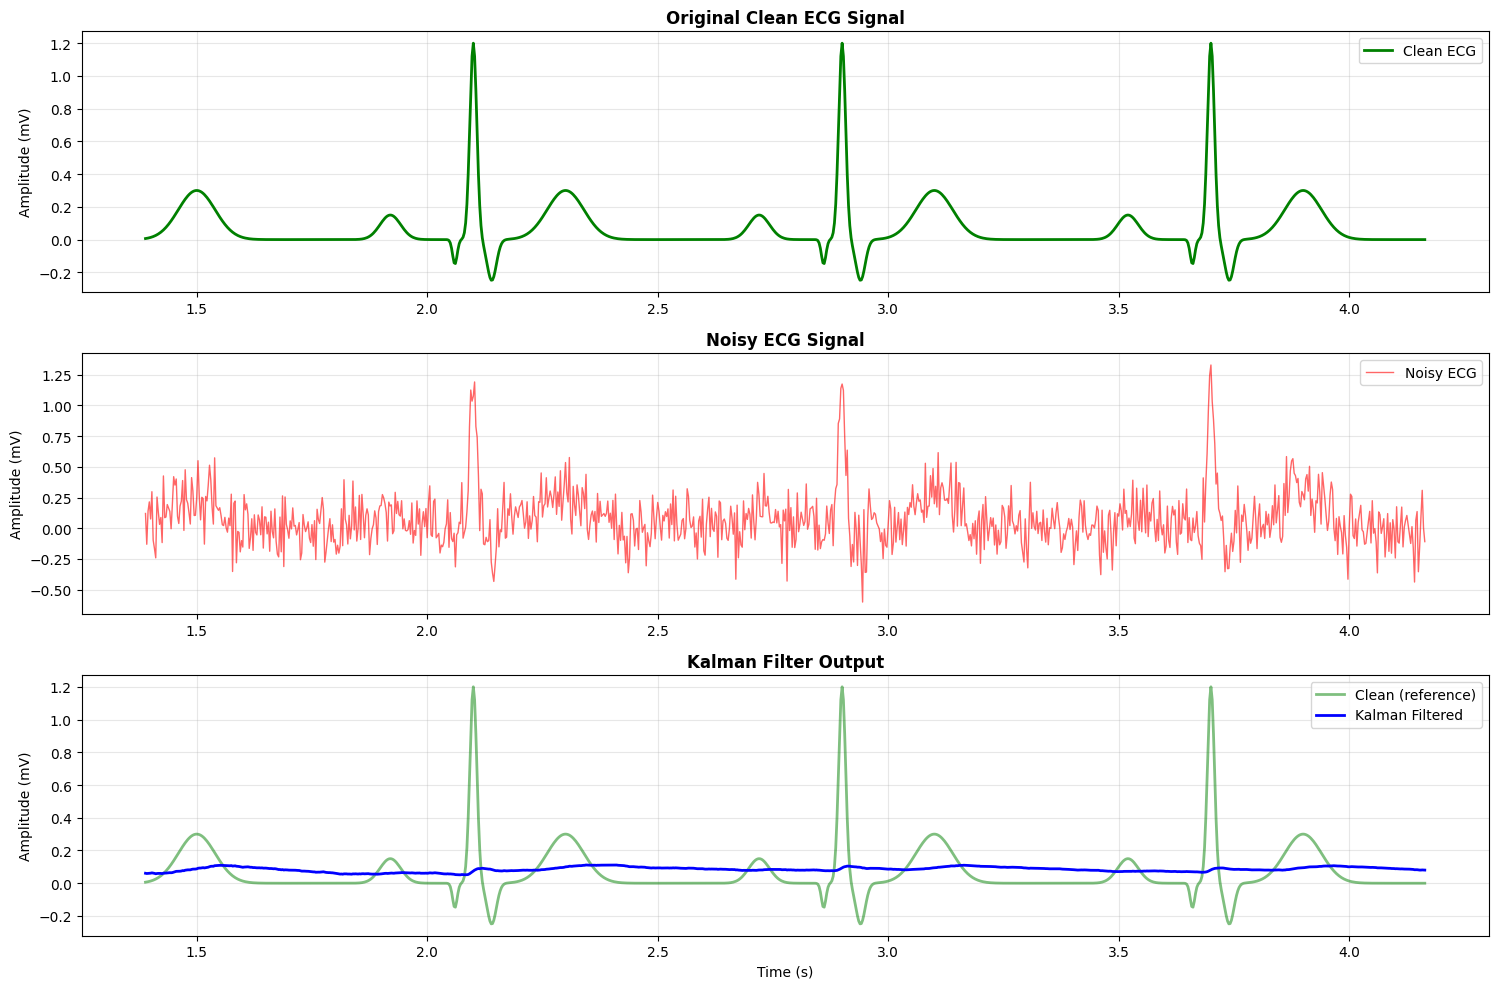


ECG FILTERING PERFORMANCE
Noisy ECG SNR:           1.71 dB
Filtered ECG SNR:        0.57 dB
SNR Improvement:         -1.15 dB


In [3]:
def generate_ecg_pqrst(duration=10, fs=360, heart_rate=75):
    """
    Generate realistic synthetic ECG signal with proper PQRST complex
    """
    t = np.arange(0, duration, 1/fs)
    ecg = np.zeros_like(t)

    rr_interval = 60.0 / heart_rate

    pqrst_params = {
        'P': {'time_offset': -0.18, 'amplitude': 0.15, 'duration': 0.09},
        'Q': {'time_offset': -0.04, 'amplitude': -0.15, 'duration': 0.02},
        'R': {'time_offset': 0.0, 'amplitude': 1.2, 'duration': 0.03},
        'S': {'time_offset': 0.04, 'amplitude': -0.25, 'duration': 0.04},
        'T': {'time_offset': 0.20, 'amplitude': 0.3, 'duration': 0.16}
    }

    num_beats = int(duration / rr_interval)

    for beat_idx in range(num_beats):
        beat_time = beat_idx * rr_interval + 0.5
        if beat_time + 0.3 > duration:
            break
        for wave_name, params in pqrst_params.items():
            peak_time = beat_time + params['time_offset']
            amplitude = params['amplitude']
            sigma = params['duration'] / 4
            wave = amplitude * np.exp(-((t - peak_time) ** 2) / (2 * sigma ** 2))
            ecg += wave

    ecg = ecg - np.mean(ecg[:int(0.2*fs)])
    return t, ecg

# Generate ECG signal
duration = 10
fs = 360
heart_rate = 75

t_ecg, clean_ecg = generate_ecg_pqrst(duration=duration, fs=fs, heart_rate=heart_rate)

# Add noise
noise_std = 0.15
noisy_ecg = clean_ecg + np.random.normal(0, noise_std, len(clean_ecg))

# Apply Kalman filter to ECG
# For ECG, we'll use a simple smoothing model
kf_ecg = KalmanFilter(dim_x=2, dim_z=1)

dt_ecg = 1/fs
kf_ecg.F = np.array([[1, dt_ecg],
                     [0, 1]])
kf_ecg.H = np.array([[1, 0]])
kf_ecg.R = np.array([[noise_std**2]])
kf_ecg.Q = np.array([[dt_ecg**4/4, dt_ecg**3/2],
                     [dt_ecg**3/2, dt_ecg**2]]) * 0.01
kf_ecg.x = np.array([[noisy_ecg[0]], [0]])
kf_ecg.P = np.eye(2) * 10

# Filter ECG
filtered_ecg = []
for z in noisy_ecg:
    kf_ecg.predict()
    kf_ecg.update(z)
    filtered_ecg.append(kf_ecg.x[0, 0])

filtered_ecg = np.array(filtered_ecg)

# Visualization
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

sample_range = slice(500, 1500)

# Clean ECG
axes[0].plot(t_ecg[sample_range], clean_ecg[sample_range], 'g-', linewidth=2, label='Clean ECG')
axes[0].set_title('Original Clean ECG Signal', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Amplitude (mV)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Noisy ECG
axes[1].plot(t_ecg[sample_range], noisy_ecg[sample_range], 'r-', alpha=0.6, linewidth=1, label='Noisy ECG')
axes[1].set_title('Noisy ECG Signal', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Amplitude (mV)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Filtered ECG
axes[2].plot(t_ecg[sample_range], clean_ecg[sample_range], 'g-', alpha=0.5, linewidth=2, label='Clean (reference)')
axes[2].plot(t_ecg[sample_range], filtered_ecg[sample_range], 'b-', linewidth=2, label='Kalman Filtered')
axes[2].set_title('Kalman Filter Output', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Amplitude (mV)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance metrics
snr_noisy = 10 * np.log10(np.mean(clean_ecg**2) / np.mean((clean_ecg - noisy_ecg)**2))
snr_filtered = 10 * np.log10(np.mean(clean_ecg**2) / np.mean((clean_ecg - filtered_ecg)**2))

print("\n" + "="*60)
print("ECG FILTERING PERFORMANCE")
print("="*60)
print(f"Noisy ECG SNR:           {snr_noisy:.2f} dB")
print(f"Filtered ECG SNR:        {snr_filtered:.2f} dB")
print(f"SNR Improvement:         {snr_filtered - snr_noisy:+.2f} dB")
print("="*60)

## Section 5: Example 3 - Heart Rate Tracking

Use Kalman filter to track instantaneous heart rate from noisy R-peak detections.

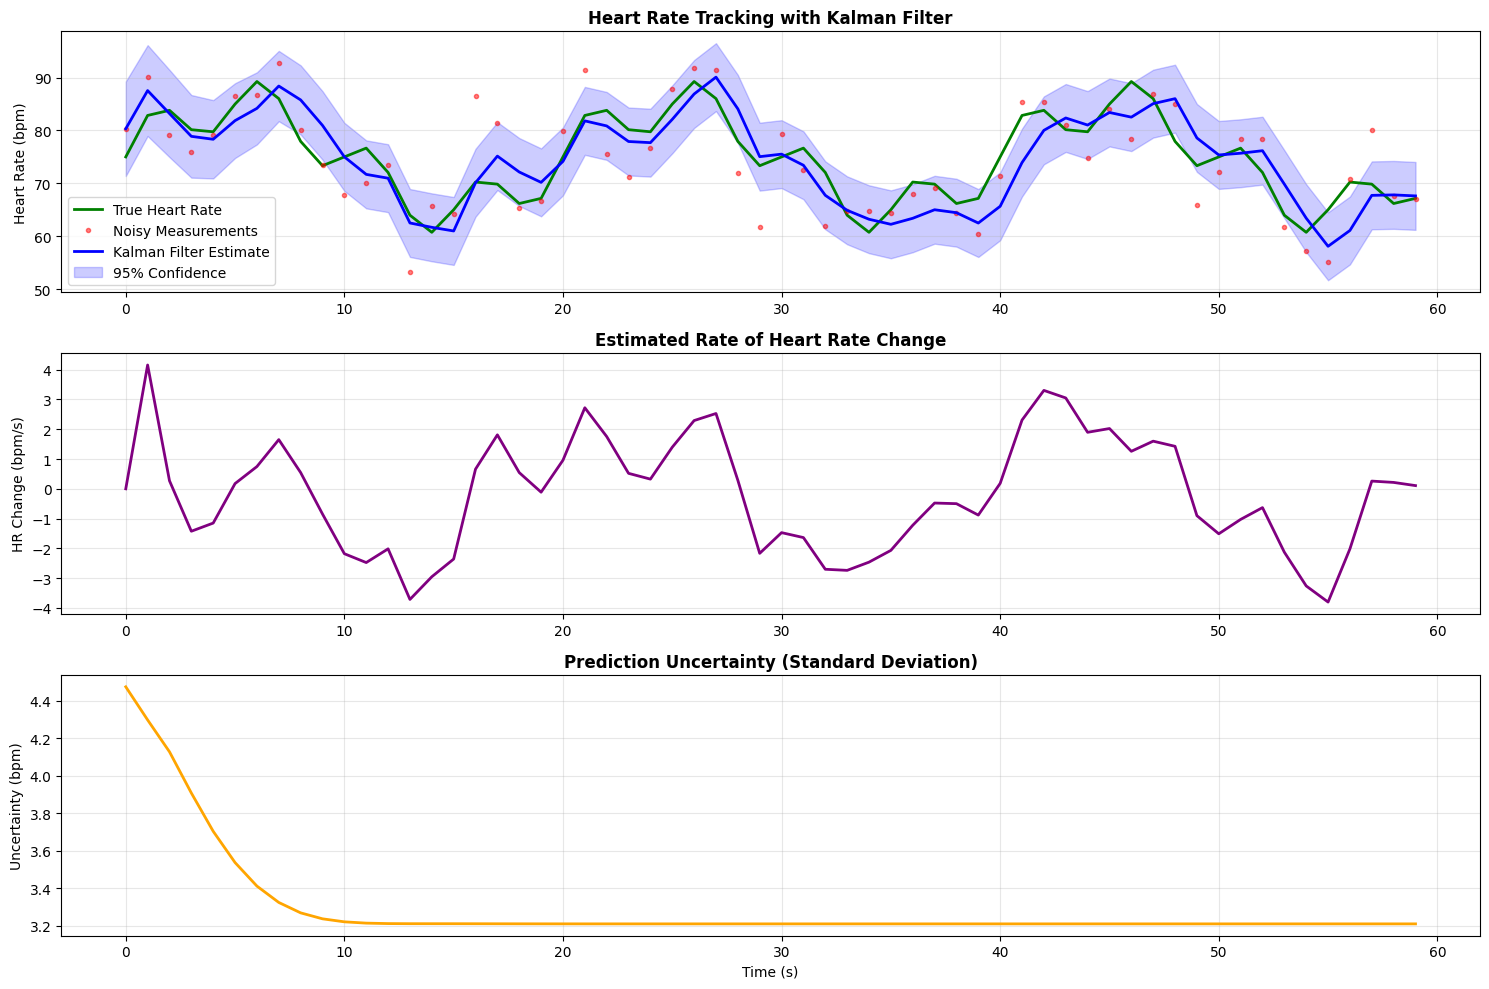


HEART RATE TRACKING PERFORMANCE
Raw Measurement MAE:     4.55 bpm
Kalman Filter MAE:       3.46 bpm
Error Reduction:         24.07%
Final Uncertainty:       3.21 bpm


In [4]:
# Simulate heart rate variability
t_hr = np.arange(0, 60, 1)  # 1 minute, 1 second intervals
N_hr = len(t_hr)

# True heart rate with variation (breathing, activity)
true_hr = 75 + 10 * np.sin(2 * np.pi * 0.05 * t_hr) + 5 * np.sin(2 * np.pi * 0.2 * t_hr)

# Noisy measurements (errors in R-peak detection)
hr_noise_std = 5.0
measured_hr = true_hr + np.random.normal(0, hr_noise_std, N_hr)

# Kalman filter for heart rate tracking
kf_hr = KalmanFilter(dim_x=2, dim_z=1)

dt_hr = 1.0
kf_hr.F = np.array([[1, dt_hr],
                    [0, 1]])
kf_hr.H = np.array([[1, 0]])
kf_hr.R = np.array([[hr_noise_std**2]])
kf_hr.Q = np.array([[dt_hr**3/3, dt_hr**2/2],
                    [dt_hr**2/2, dt_hr]]) * 0.5
kf_hr.x = np.array([[measured_hr[0]], [0]])
kf_hr.P = np.eye(2) * 50

# Filter heart rate
filtered_hr = []
filtered_hr_rate = []
prediction_uncertainty = []

for z in measured_hr:
    kf_hr.predict()
    kf_hr.update(z)
    filtered_hr.append(kf_hr.x[0, 0])
    filtered_hr_rate.append(kf_hr.x[1, 0])
    prediction_uncertainty.append(np.sqrt(kf_hr.P[0, 0]))

filtered_hr = np.array(filtered_hr)
filtered_hr_rate = np.array(filtered_hr_rate)
prediction_uncertainty = np.array(prediction_uncertainty)

# Visualization
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# Heart rate tracking
axes[0].plot(t_hr, true_hr, 'g-', linewidth=2, label='True Heart Rate')
axes[0].plot(t_hr, measured_hr, 'r.', alpha=0.5, markersize=6, label='Noisy Measurements')
axes[0].plot(t_hr, filtered_hr, 'b-', linewidth=2, label='Kalman Filter Estimate')
axes[0].fill_between(t_hr,
                     filtered_hr - 2*prediction_uncertainty,
                     filtered_hr + 2*prediction_uncertainty,
                     alpha=0.2, color='blue', label='95% Confidence')
axes[0].set_title('Heart Rate Tracking with Kalman Filter', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Heart Rate (bpm)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Heart rate change rate
axes[1].plot(t_hr, filtered_hr_rate, 'purple', linewidth=2)
axes[1].set_title('Estimated Rate of Heart Rate Change', fontsize=12, fontweight='bold')
axes[1].set_ylabel('HR Change (bpm/s)')
axes[1].grid(True, alpha=0.3)

# Prediction uncertainty
axes[2].plot(t_hr, prediction_uncertainty, 'orange', linewidth=2)
axes[2].set_title('Prediction Uncertainty (Standard Deviation)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Uncertainty (bpm)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance metrics
mae_raw = np.mean(np.abs(measured_hr - true_hr))
mae_filtered = np.mean(np.abs(filtered_hr - true_hr))

print("\n" + "="*60)
print("HEART RATE TRACKING PERFORMANCE")
print("="*60)
print(f"Raw Measurement MAE:     {mae_raw:.2f} bpm")
print(f"Kalman Filter MAE:       {mae_filtered:.2f} bpm")
print(f"Error Reduction:         {(1 - mae_filtered/mae_raw)*100:.2f}%")
print(f"Final Uncertainty:       {prediction_uncertainty[-1]:.2f} bpm")
print("="*60)

## Section 6: Extended Kalman Filter (EKF) for Nonlinear Systems

When the system dynamics are nonlinear, we use the Extended Kalman Filter which linearizes around the current estimate.

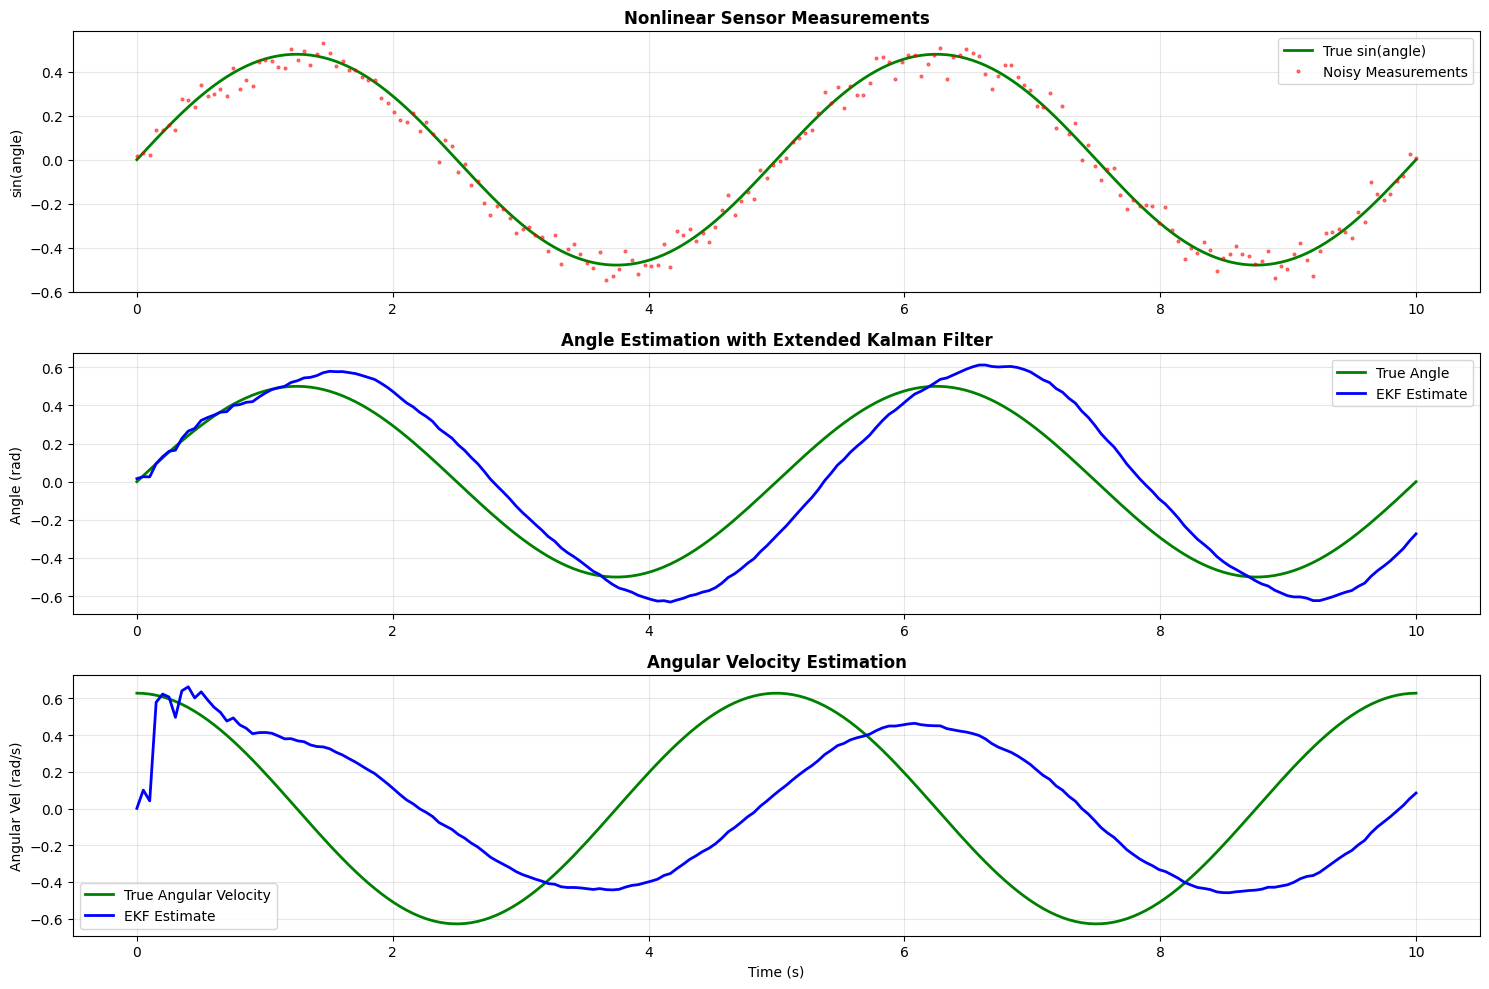


EXTENDED KALMAN FILTER PERFORMANCE
Angle Estimation RMSE:   0.1816 rad (10.41°)


In [5]:
# Example: Track angle and angular velocity with nonlinear sensor
# This could represent joint angle tracking from accelerometer data

def hx(x):
    """Measurement function: nonlinear sensor model"""
    # Sensor measures sin(angle) (like a simple accelerometer)
    return np.array([np.sin(x[0])])

def HJacobian(x):
    """Jacobian of measurement function"""
    return np.array([[np.cos(x[0]), 0]])

# Generate true trajectory
t_angle = np.linspace(0, 10, 200)
dt_angle = t_angle[1] - t_angle[0]
true_angle = 0.5 * np.sin(2 * np.pi * 0.2 * t_angle)
true_angular_vel = 0.5 * 2 * np.pi * 0.2 * np.cos(2 * np.pi * 0.2 * t_angle)

# Generate nonlinear measurements with noise
sensor_noise_std = 0.05
measurements_nonlinear = np.sin(true_angle) + np.random.normal(0, sensor_noise_std, len(t_angle))

# Initialize Extended Kalman Filter
ekf = ExtendedKalmanFilter(dim_x=2, dim_z=1)

# State transition (linear)
ekf.F = np.array([[1, dt_angle],
                  [0, 1]])

# Process and measurement noise
ekf.R = np.array([[sensor_noise_std**2]])
ekf.Q = np.array([[dt_angle**4/4, dt_angle**3/2],
                  [dt_angle**3/2, dt_angle**2]]) * 0.01

# Initial state
ekf.x = np.array([0, 0])
ekf.P = np.eye(2) * 1

# Run EKF
filtered_angle = []
filtered_angular_vel = []

for z in measurements_nonlinear:
    ekf.predict()
    ekf.update(np.array([z]), HJacobian, hx)
    filtered_angle.append(ekf.x[0])
    filtered_angular_vel.append(ekf.x[1])

filtered_angle = np.array(filtered_angle)
filtered_angular_vel = np.array(filtered_angular_vel)

# Visualization
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# Measurements (nonlinear)
axes[0].plot(t_angle, np.sin(true_angle), 'g-', linewidth=2, label='True sin(angle)')
axes[0].plot(t_angle, measurements_nonlinear, 'r.', alpha=0.5, markersize=4, label='Noisy Measurements')
axes[0].set_title('Nonlinear Sensor Measurements', fontsize=12, fontweight='bold')
axes[0].set_ylabel('sin(angle)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Angle estimation
axes[1].plot(t_angle, true_angle, 'g-', linewidth=2, label='True Angle')
axes[1].plot(t_angle, filtered_angle, 'b-', linewidth=2, label='EKF Estimate')
axes[1].set_title('Angle Estimation with Extended Kalman Filter', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Angle (rad)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Angular velocity estimation
axes[2].plot(t_angle, true_angular_vel, 'g-', linewidth=2, label='True Angular Velocity')
axes[2].plot(t_angle, filtered_angular_vel, 'b-', linewidth=2, label='EKF Estimate')
axes[2].set_title('Angular Velocity Estimation', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Angular Vel (rad/s)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance
angle_rmse = np.sqrt(np.mean((filtered_angle - true_angle)**2))
print("\n" + "="*60)
print("EXTENDED KALMAN FILTER PERFORMANCE")
print("="*60)
print(f"Angle Estimation RMSE:   {angle_rmse:.4f} rad ({np.rad2deg(angle_rmse):.2f}°)")
print("="*60)

## Section 7: Comparison - Kalman Filter vs Traditional Filters

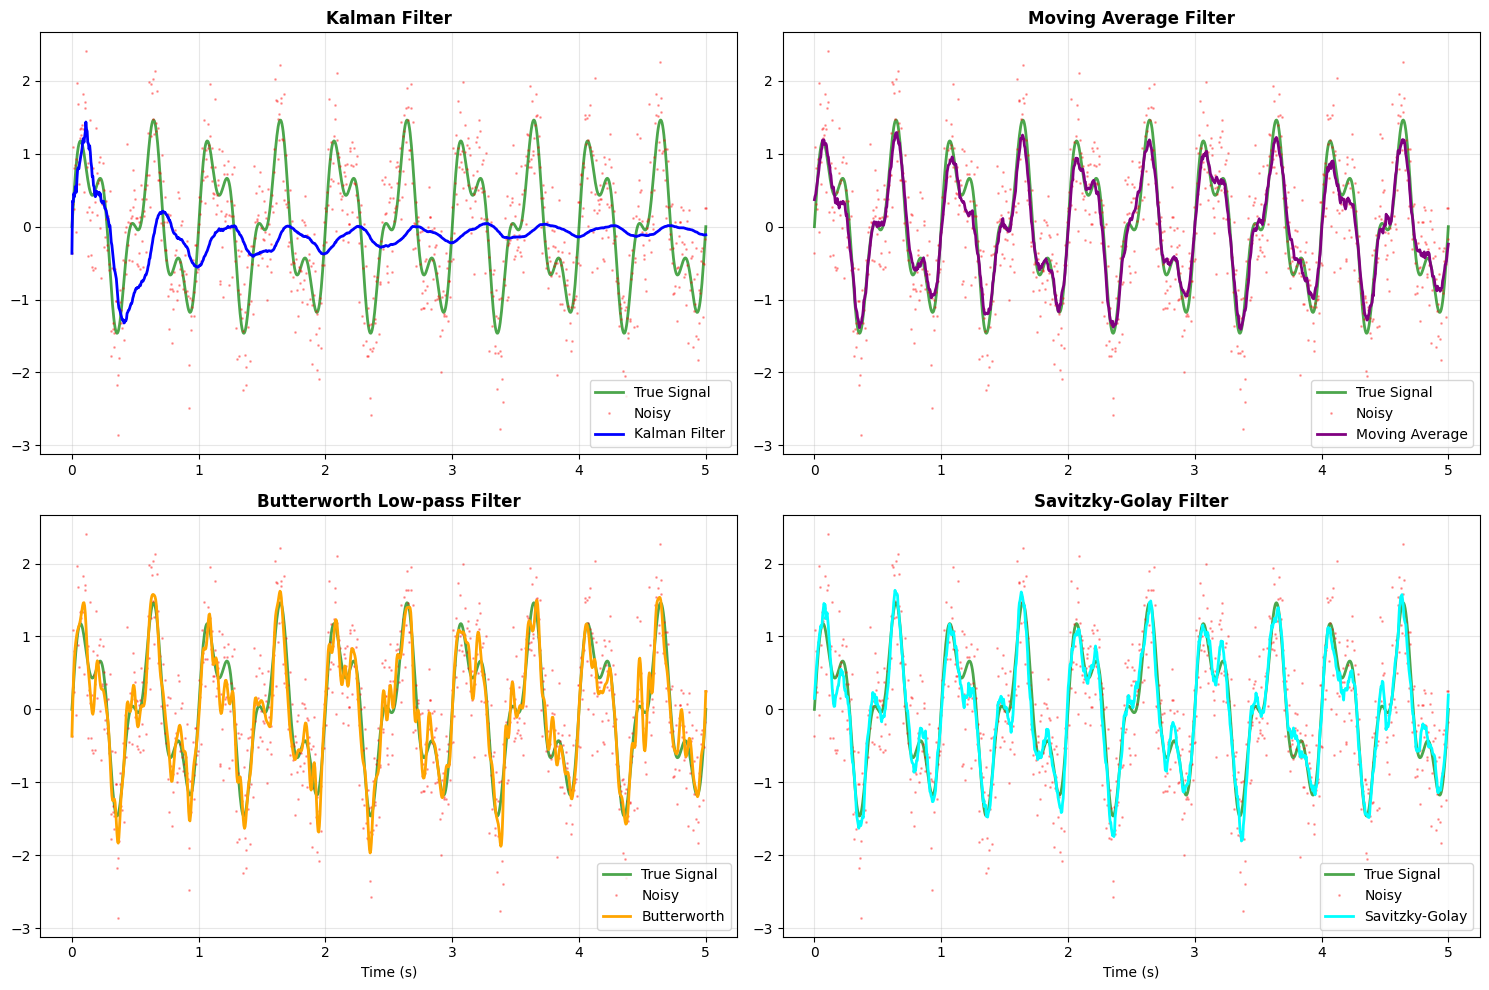


FILTER COMPARISON
        Filter     RMSE           Latency Adaptivity
Savitzky-Golay 0.159598        10 samples      Fixed
Moving Average 0.172175        10 samples      Fixed
   Butterworth 0.213394 None (zero-phase)      Fixed
        Kalman 0.786413     None (causal)   Adaptive


In [6]:
# Generate test signal
t_comp = np.linspace(0, 5, 1000)
true_signal = np.sin(2 * np.pi * 2 * t_comp) + 0.5 * np.sin(2 * np.pi * 5 * t_comp)
noisy_signal = true_signal + np.random.normal(0, 0.5, len(t_comp))

# 1. Kalman Filter
kf_comp = KalmanFilter(dim_x=2, dim_z=1)
dt_comp = t_comp[1] - t_comp[0]
kf_comp.F = np.array([[1, dt_comp], [0, 1]])
kf_comp.H = np.array([[1, 0]])
kf_comp.R = np.array([[0.25]])
kf_comp.Q = np.array([[dt_comp**4/4, dt_comp**3/2], [dt_comp**3/2, dt_comp**2]]) * 0.01
kf_comp.x = np.array([[noisy_signal[0]], [0]])
kf_comp.P = np.eye(2) * 10

kalman_output = []
for z in noisy_signal:
    kf_comp.predict()
    kf_comp.update(z)
    kalman_output.append(kf_comp.x[0, 0])
kalman_output = np.array(kalman_output)

# 2. Moving Average Filter
window_size = 20
ma_output = np.convolve(noisy_signal, np.ones(window_size)/window_size, mode='same')

# 3. Low-pass Butterworth Filter
b, a = signal.butter(4, 0.2, 'low')
butterworth_output = signal.filtfilt(b, a, noisy_signal)

# 4. Savitzky-Golay Filter
savgol_output = signal.savgol_filter(noisy_signal, window_length=21, polyorder=3)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Kalman Filter
axes[0, 0].plot(t_comp, true_signal, 'g-', linewidth=2, alpha=0.7, label='True Signal')
axes[0, 0].plot(t_comp, noisy_signal, 'r.', alpha=0.3, markersize=2, label='Noisy')
axes[0, 0].plot(t_comp, kalman_output, 'b-', linewidth=2, label='Kalman Filter')
axes[0, 0].set_title('Kalman Filter', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Moving Average
axes[0, 1].plot(t_comp, true_signal, 'g-', linewidth=2, alpha=0.7, label='True Signal')
axes[0, 1].plot(t_comp, noisy_signal, 'r.', alpha=0.3, markersize=2, label='Noisy')
axes[0, 1].plot(t_comp, ma_output, 'purple', linewidth=2, label='Moving Average')
axes[0, 1].set_title('Moving Average Filter', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Butterworth
axes[1, 0].plot(t_comp, true_signal, 'g-', linewidth=2, alpha=0.7, label='True Signal')
axes[1, 0].plot(t_comp, noisy_signal, 'r.', alpha=0.3, markersize=2, label='Noisy')
axes[1, 0].plot(t_comp, butterworth_output, 'orange', linewidth=2, label='Butterworth')
axes[1, 0].set_title('Butterworth Low-pass Filter', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Time (s)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Savitzky-Golay
axes[1, 1].plot(t_comp, true_signal, 'g-', linewidth=2, alpha=0.7, label='True Signal')
axes[1, 1].plot(t_comp, noisy_signal, 'r.', alpha=0.3, markersize=2, label='Noisy')
axes[1, 1].plot(t_comp, savgol_output, 'cyan', linewidth=2, label='Savitzky-Golay')
axes[1, 1].set_title('Savitzky-Golay Filter', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Time (s)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance comparison
import pandas as pd

rmse_kalman = np.sqrt(np.mean((kalman_output - true_signal)**2))
rmse_ma = np.sqrt(np.mean((ma_output - true_signal)**2))
rmse_butter = np.sqrt(np.mean((butterworth_output - true_signal)**2))
rmse_savgol = np.sqrt(np.mean((savgol_output - true_signal)**2))

comparison_df = pd.DataFrame({
    'Filter': ['Kalman', 'Moving Average', 'Butterworth', 'Savitzky-Golay'],
    'RMSE': [rmse_kalman, rmse_ma, rmse_butter, rmse_savgol],
    'Latency': ['None (causal)', f'{window_size//2} samples', 'None (zero-phase)', f'{10} samples'],
    'Adaptivity': ['Adaptive', 'Fixed', 'Fixed', 'Fixed']
})
comparison_df = comparison_df.sort_values('RMSE')

print("\n" + "="*80)
print("FILTER COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

## Section 8: Biomedical Applications of Kalman Filters

In [7]:
import pandas as pd

print("\n" + "="*80)
print("BIOMEDICAL APPLICATIONS OF KALMAN FILTERS")
print("="*80)

applications = {
    "ECG Signal Processing": [
        "- Real-time denoising of ECG signals",
        "- R-peak detection and tracking",
        "- Heart rate variability analysis",
        "- Arrhythmia detection enhancement"
    ],
    "Respiratory Monitoring": [
        "- Respiratory rate estimation",
        "- Breath-to-breath variability tracking",
        "- Sleep apnea detection",
        "- Ventilator synchronization"
    ],
    "Blood Pressure Estimation": [
        "- Continuous BP tracking from PPG",
        "- Pulse transit time estimation",
        "- Cuffless BP monitoring",
        "- Beat-to-beat BP variability"
    ],
    "Motion Tracking": [
        "- Joint angle estimation (gait analysis)",
        "- IMU sensor fusion for orientation",
        "- Tremor quantification (Parkinson's)",
        "- Rehabilitation progress monitoring"
    ],
    "EEG Processing": [
        "- Artifact removal",
        "- Brain state tracking",
        "- Seizure prediction",
        "- BCI signal enhancement"
    ],
    "Glucose Monitoring": [
        "- CGM noise reduction",
        "- Glucose trend prediction",
        "- Insulin pump control (artificial pancreas)",
        "- Hypoglycemia prediction"
    ]
}

for app, details in applications.items():
    print(f"\n{app}:")
    for detail in details:
        print(f"  {detail}")

print("\n" + "="*80)


BIOMEDICAL APPLICATIONS OF KALMAN FILTERS

ECG Signal Processing:
  - Real-time denoising of ECG signals
  - R-peak detection and tracking
  - Heart rate variability analysis
  - Arrhythmia detection enhancement

Respiratory Monitoring:
  - Respiratory rate estimation
  - Breath-to-breath variability tracking
  - Sleep apnea detection
  - Ventilator synchronization

Blood Pressure Estimation:
  - Continuous BP tracking from PPG
  - Pulse transit time estimation
  - Cuffless BP monitoring
  - Beat-to-beat BP variability

Motion Tracking:
  - Joint angle estimation (gait analysis)
  - IMU sensor fusion for orientation
  - Tremor quantification (Parkinson's)
  - Rehabilitation progress monitoring

EEG Processing:
  - Artifact removal
  - Brain state tracking
  - Seizure prediction
  - BCI signal enhancement

Glucose Monitoring:
  - CGM noise reduction
  - Glucose trend prediction
  - Insulin pump control (artificial pancreas)
  - Hypoglycemia prediction



## Section 9: Advantages and Limitations

In [8]:
import pandas as pd

# Advantages vs Limitations
comparison_data = {
    'Aspect': [
        'Optimality',
        'Real-time',
        'Uncertainty',
        'Model-based',
        'Computational',
        'Adaptivity'
    ],
    'Advantages': [
        'Optimal for linear Gaussian systems',
        'Recursive, causal, no future data needed',
        'Provides uncertainty estimates',
        'Incorporates system knowledge',
        'Efficient O(n²) complexity',
        'Automatically adapts Kalman gain'
    ],
    'Limitations': [
        'Requires accurate system model',
        'Performance degrades with model mismatch',
        'Assumes Gaussian noise',
        'Need to tune Q and R matrices',
        'EKF/UKF more complex for nonlinear systems',
        'Can diverge with poor initialization'
    ]
}

df_comparison = pd.DataFrame(comparison_data)

print("\n" + "="*100)
print("KALMAN FILTER: ADVANTAGES VS LIMITATIONS")
print("="*100)
print(df_comparison.to_string(index=False))
print("="*100)

# Filter variants comparison
variants_data = {
    'Filter Type': ['Linear KF', 'Extended KF (EKF)', 'Unscented KF (UKF)', 'Particle Filter'],
    'System Type': ['Linear', 'Nonlinear', 'Nonlinear', 'Nonlinear'],
    'Complexity': ['Low', 'Medium', 'Medium-High', 'High'],
    'Accuracy': ['Optimal', 'Good', 'Better', 'Best'],
    'Use Case': ['Simple tracking', 'Mild nonlinearity', 'Strong nonlinearity', 'Non-Gaussian']
}

df_variants = pd.DataFrame(variants_data)

print("\n" + "="*100)
print("KALMAN FILTER VARIANTS COMPARISON")
print("="*100)
print(df_variants.to_string(index=False))
print("="*100)


KALMAN FILTER: ADVANTAGES VS LIMITATIONS
       Aspect                               Advantages                                Limitations
   Optimality      Optimal for linear Gaussian systems             Requires accurate system model
    Real-time Recursive, causal, no future data needed   Performance degrades with model mismatch
  Uncertainty           Provides uncertainty estimates                     Assumes Gaussian noise
  Model-based            Incorporates system knowledge              Need to tune Q and R matrices
Computational               Efficient O(n²) complexity EKF/UKF more complex for nonlinear systems
   Adaptivity         Automatically adapts Kalman gain       Can diverge with poor initialization

KALMAN FILTER VARIANTS COMPARISON
       Filter Type System Type  Complexity Accuracy            Use Case
         Linear KF      Linear         Low  Optimal     Simple tracking
 Extended KF (EKF)   Nonlinear      Medium     Good   Mild nonlinearity
Unscented KF (UKF)   

## Section 10: Practical Tuning Guidelines

In [9]:
print("\n" + "="*80)
print("KALMAN FILTER TUNING GUIDELINES")
print("="*80)
print("""
1. PROCESS NOISE COVARIANCE (Q):
   → Represents uncertainty in system model
   → Larger Q: Filter responds faster, more noise
   → Smaller Q: Filter responds slower, smoother output
   → Rule of thumb: Start with small Q, increase if tracking is slow

2. MEASUREMENT NOISE COVARIANCE (R):
   → Represents sensor noise level
   → Larger R: Filter trusts model more than measurements
   → Smaller R: Filter trusts measurements more than model
   → Best practice: Estimate from actual sensor data statistics

3. INITIAL STATE COVARIANCE (P):
   → Represents initial uncertainty
   → Large P: Filter adapts quickly at start
   → Converges to steady-state regardless of initial value
   → Typical: P = I × (large value like 100-1000)

4. STATE TRANSITION MATRIX (F):
   → Model your system dynamics accurately
   → Common models:
     • Constant position: F = [1]
     • Constant velocity: F = [[1, dt], [0, 1]]
     • Constant acceleration: F = [[1, dt, dt²/2], [0, 1, dt], [0, 0, 1]]

5. TUNING STRATEGY:
   a) Start with measurement noise R from sensor specs
   b) Set Q small initially
   c) Increase Q if filter is too slow to track changes
   d) Decrease Q if output is too noisy
   e) Balance Q/R ratio for optimal performance

6. COMMON PITFALLS:
   ✗ Setting Q = 0 (filter can't adapt)
   ✗ Setting R = 0 (numerical instability)
   ✗ Poor state model selection
   ✗ Not validating with real data
   ✗ Ignoring filter divergence checks
""")
print("="*80)

print("\nDemonstration Complete!")
print("\nKey Takeaways:")
print("  ✓ Kalman filters provide optimal estimation for linear Gaussian systems")
print("  ✓ They track state AND uncertainty simultaneously")
print("  ✓ Real-time, recursive, and computationally efficient")
print("  ✓ Widely used in biomedical signal processing and monitoring")
print("  ✓ EKF/UKF extend to nonlinear systems")
print("  ✓ Proper tuning of Q and R is critical for performance")


KALMAN FILTER TUNING GUIDELINES

1. PROCESS NOISE COVARIANCE (Q):
   → Represents uncertainty in system model
   → Larger Q: Filter responds faster, more noise
   → Smaller Q: Filter responds slower, smoother output
   → Rule of thumb: Start with small Q, increase if tracking is slow

2. MEASUREMENT NOISE COVARIANCE (R):
   → Represents sensor noise level
   → Larger R: Filter trusts model more than measurements
   → Smaller R: Filter trusts measurements more than model
   → Best practice: Estimate from actual sensor data statistics

3. INITIAL STATE COVARIANCE (P):
   → Represents initial uncertainty
   → Large P: Filter adapts quickly at start
   → Converges to steady-state regardless of initial value
   → Typical: P = I × (large value like 100-1000)

4. STATE TRANSITION MATRIX (F):
   → Model your system dynamics accurately
   → Common models:
     • Constant position: F = [1]
     • Constant velocity: F = [[1, dt], [0, 1]]
     • Constant acceleration: F = [[1, dt, dt²/2], [0, 1, 